In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from pylab import plt
%matplotlib inline

In [2]:
class Config:
    lr = 0.0002
    nz = 100 # noise dimension
    image_size = 64
    image_size2 = 64
    nc = 3 # chanel of img 
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta1 = 0.5
    batch_size = 32
    max_epoch = 10 # =1 when debug
    workers = 2
    gpu = True # use gpu or not
    
opt=Config()

In [3]:
# data preprocess
transform=transforms.Compose([
                transforms.Resize(opt.image_size) ,
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3,[0.5]*3)
                ])

dataset=CIFAR10(root='cifar10/',transform=transform,download=True)
# dataloader with multiprocessing
dataloader=t.utils.data.DataLoader(dataset,
                                   opt.batch_size,
                                   shuffle = True,
                                   num_workers=opt.workers)

Files already downloaded and verified


In [4]:
# define model
netg = nn.Sequential(
    nn.ConvTranspose2d(opt.nz,opt.ngf*8,4,1,0,bias=False),
    nn.BatchNorm2d(opt.ngf*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*2,opt.ngf,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf,opt.nc,4,2,1,bias=False),
    nn.Tanh()
)

netd = nn.Sequential(
    nn.Conv2d(opt.nc,opt.ndf,4,2,1,bias=False),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf,opt.ndf*2,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*2),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*2,opt.ndf*4,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*4),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*4,opt.ndf*8,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*8),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*8,1,4,1,0,bias=False),
    nn.Sigmoid()
)

In [5]:
# optimizer
optimizerD = Adam(netd.parameters(),lr=opt.lr,betas=(opt.beta1,0.999))
optimizerG = Adam(netg.parameters(),lr=opt.lr,betas=(opt.beta1,0.999))

# criterion
criterion = nn.BCELoss()

fix_noise = Variable(t.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1))
if opt.gpu:
    fix_noise = fix_noise.cuda()
    netd.cuda()
    netg.cuda()
    criterion.cuda() # it's a good habit

begin training, be patient


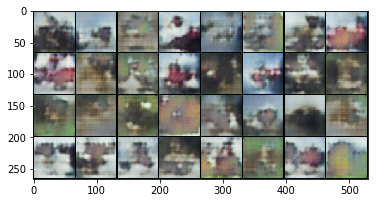

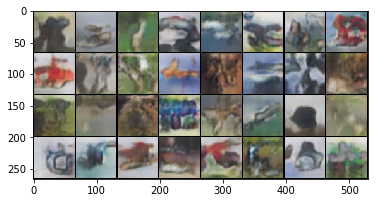

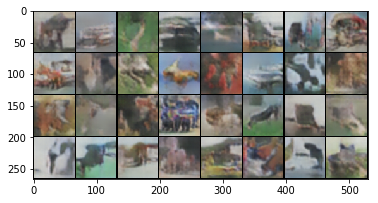

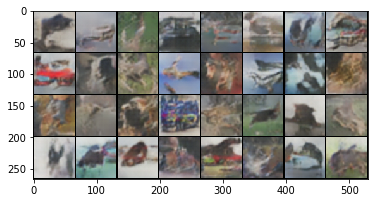

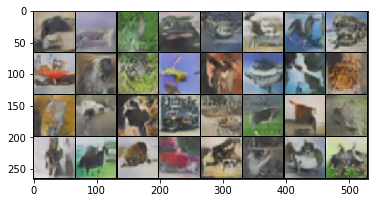

In [6]:
# begin training
print('begin training, be patient')

for epoch in xrange(opt.max_epoch):
    for ii, data in enumerate(dataloader,0):
        real,_=data
        input = Variable(real)
        label = Variable(t.ones(input.size(0))) # 1 for real
        noise = t.randn(input.size(0),opt.nz,1,1)
        noise = Variable(noise)
        
        if opt.gpu:
            noise = noise.cuda()
            input = input.cuda()
            label = label.cuda()
        
        # ----- train netd -----
        netd.zero_grad()
        ## train netd with real img
        output=netd(input)
        error_real=criterion(output.squeeze(),label)
        error_real.backward()
        D_x=output.data.mean()
        ## train netd with fake img
        fake_pic=netg(noise).detach()
        output2=netd(fake_pic)
        label.data.fill_(0) # 0 for fake
        error_fake=criterion(output2.squeeze(),label)
        error_fake.backward()
        D_x2=output2.data.mean()
        error_D=error_real+error_fake
        optimizerD.step()
        
        # ------ train netg -------
        netg.zero_grad()
        label.data.fill_(1)
        noise.data.normal_(0,1)
        fake_pic=netg(noise)
        output=netd(fake_pic)
        error_G=criterion(output.squeeze(),label)
        error_G.backward()
        optimizerG.step()
        D_G_z2=output.data.mean()
        
#         if ii%500==0:
#             print ('{ii}/{epoch} lossD:{error_D},lossG:{error_G},{D_x2},{D_G_z2},{D_x}'.format(
#                     ii=ii,epoch=epoch,\
#                     error_D=error_D.data[0],\
#                     error_G=error_G.data[0],\
#                     D_x2=D_x2,D_G_z2=D_G_z2,D_x=D_x))
    if epoch % 2 ==0:
        fake_u=netg(fix_noise)
        imgs = make_grid(fake_u.data*0.5+0.5).cpu() # CHW
        plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
        plt.show()

In [7]:
t.save(netd.state_dict(),'dcgan_netd.pth')
t.save(netg.state_dict(),'dcgan_netg.pth')